# Experimentation with different numbers of enrollment utterances
## ASV evaluation with the anonymized audiofiles by increasing the number of enrollment utterances
1. The number of enrollment utterances is gradually increased for both ignorant and lazy-informed scenario
2. We run the experiments multiple times for different target selections (i.e. 5 different files) to avoid bias
3. The speakers with less than the minimum number of utterances are filtered out
4. The number of trial utterances is fixed to 1 (but randomly selected to avoid bias)

<b> Hypothesis</b>: The EER of the ASV system will decrease, as the number of enrollment
utterances increases. A smaller number of enrollment data per speaker leads
to less robust voice models that do not capture efficiently the enroll’ unique
voice characteristics, thereby decreasing the system’s ability to accept or reject
the speaker correctly <br>

The following VC-Models are evaluated:
1. StarGan-VC
2. kNN-VC


The following datasets from librispeech are evaluated:
1. ls-test-clean and ls-test-other
2. ls-train-other-500

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt



/tmp/ipykernel_86376/2862603903.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. Evaluation with ls-test-clean and ls-test-other (71 out of 73 speakers)
The speakers with less than 30 utterances are filtered out. We run the experiments for 5 different target selections (files).

### a) StarGAN-VC

In [2]:
file_pattern = "results_stargan_enroll/ls-test-clean_other/stargan_tco_num_enrolls#*.txt" 

##### Averaging over 5 different target selections


In [3]:
all_files = glob.glob(file_pattern)

# Initialize an empty list to store dataframes
all_dfs = []
for filename in all_files:
    df = pd.read_csv(filename, sep='\s+')
    df['eer_ignorant'] *= 100  # Convert to percentage
    df['eer_lazy-informed'] *= 100  # Convert to percentage
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)



In [4]:
# Aggregate and calculate overall mean and standard deviation for each number of enroll
overall_stats = full_df.groupby('num_of_enrolls').agg({'eer_ignorant': ['mean', 'std'], 'eer_lazy-informed': ['mean', 'std']})
full_df = full_df[(full_df['num_of_enrolls'] % 5 == 0) | (full_df['num_of_enrolls'] == 1)]

# Aggregate and calculate mean and standard deviation for each group of 'num'
overall_stats = full_df.groupby('num_of_enrolls').agg({
    'eer_ignorant': ['mean', 'std'],
    'eer_lazy-informed': ['mean', 'std']
})

overall_stats.to_csv('overall_stats/overall_stats_stargan_tco_num_enrolls.csv', index=True)  # Set index=False if you do not want to include the DataFrame index as a column in the CSV file

# Display the overall statistics in a table
print("Overall statistics for ls-test-clean and other:")
display(overall_stats)

Overall statistics for ls-test-clean and other:


eer_ignorant           eer_lazy-informed          
                       mean       std              mean       std
num_of_enrolls                                                   
1                 38.546881  2.209491         30.198793  2.247385
5                 35.945272  2.091782         25.235010  2.831749
10                34.937626  2.469926         23.166197  2.570564
15                36.022535  2.082634         22.709859  2.401271
20                35.441046  2.579168         22.598390  2.205709
25                35.121932  2.522326         22.963380  2.806701
30                34.716700  2.145470         23.235412  1.785091

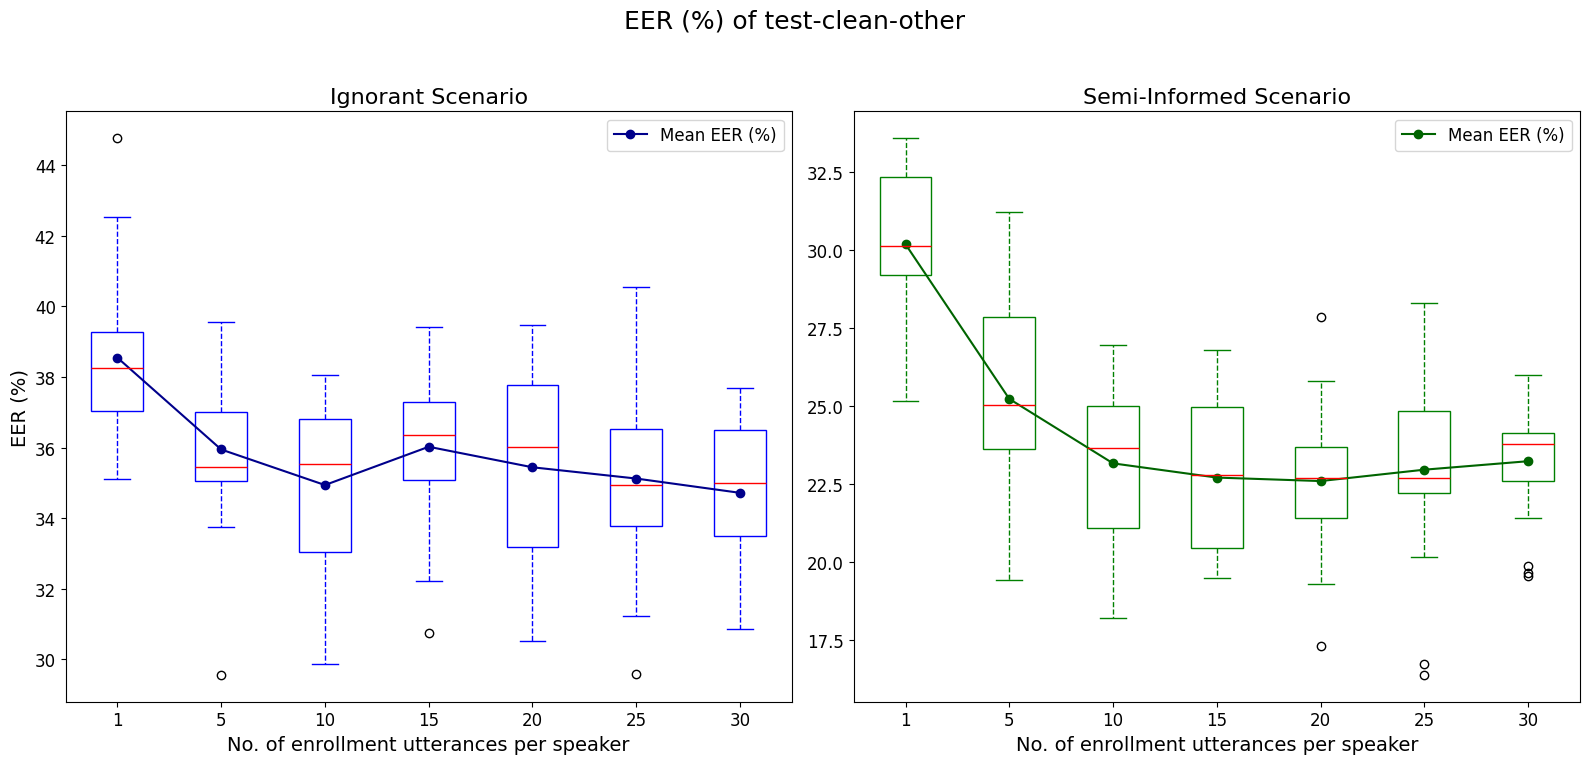

In [5]:
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')

# Customizing the overall appearance
plt.suptitle('EER (%) of test-clean-other', fontsize=18, fontweight='normal')

# Ignorant Scenario
ignorant_means = full_df.groupby('num_of_enrolls')['eer_ignorant'].mean()
ignorant_data = [group['eer_ignorant'].values for _, group in full_df.groupby('num_of_enrolls')]
axs[0].boxplot(ignorant_data, labels=ignorant_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='blue'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='blue', linestyle='--'),
               capprops=dict(color='blue'))
axs[0].plot(range(1, len(ignorant_means) + 1), ignorant_means, color='darkblue', marker='o', linestyle='-', label='Mean EER (%)')
axs[0].set_title('Ignorant Scenario', fontsize=16, fontweight='normal')
axs[0].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[0].set_ylabel('EER (%)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Lazy-Informed Scenario
lazy_informed_means = full_df.groupby('num_of_enrolls')['eer_lazy-informed'].mean()
lazy_informed_data = [group['eer_lazy-informed'].values for _, group in full_df.groupby('num_of_enrolls')]
axs[1].boxplot(lazy_informed_data, labels=lazy_informed_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='green'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='green', linestyle='--'),
               capprops=dict(color='green'))
axs[1].plot(range(1, len(lazy_informed_means) + 1), lazy_informed_means, color='darkgreen', marker='o', linestyle='-', label='Mean EER (%)')
axs[1].set_title('Semi-Informed Scenario', fontsize=16, fontweight='normal')
axs[1].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('overall_stats/boxplots/stargan_tco_enrolls.png')
plt.savefig('overall_stats/boxplots/stargan_tco_enrolls.pdf')  
plt.show()




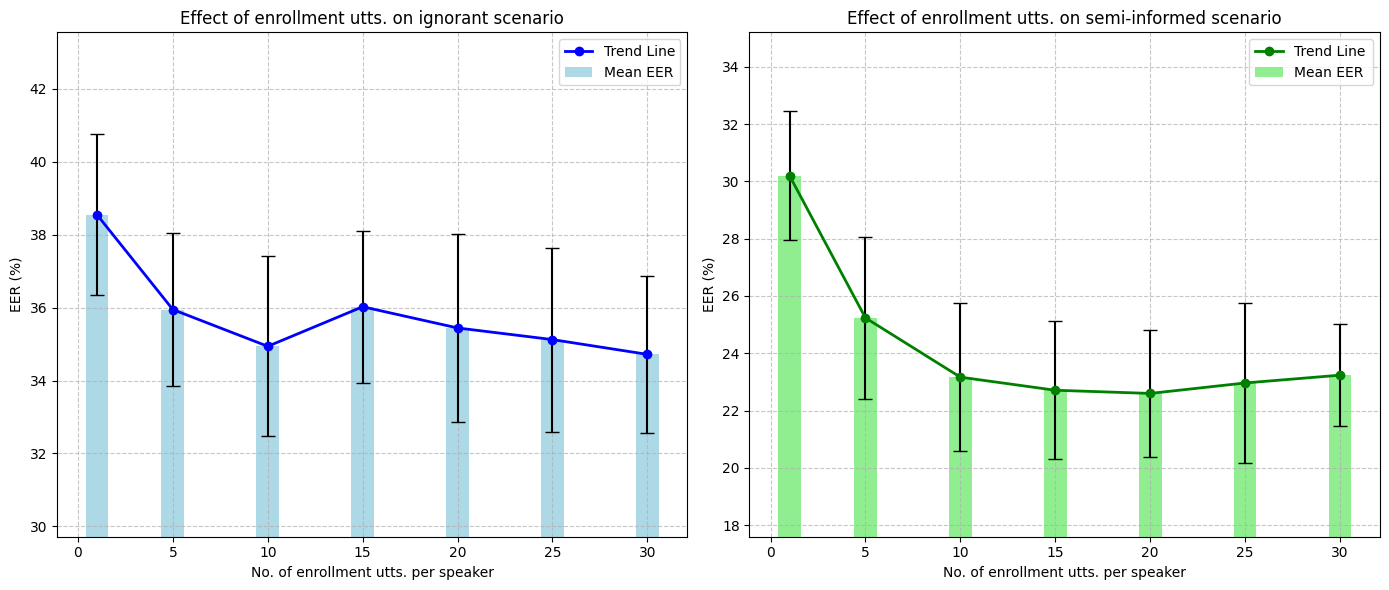

In [6]:

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for eer_ignorant
axs[0].bar(overall_stats.index, overall_stats['eer_ignorant']['mean'], yerr=overall_stats['eer_ignorant']['std'], capsize=5, color='lightblue', width=1.2, label='Mean EER')
axs[0].plot(overall_stats.index, overall_stats['eer_ignorant']['mean'], marker='o', color='blue', linestyle='-', linewidth=2, label='Trend Line')
axs[0].set_title('Effect of enrollment utts. on ignorant scenario')
axs[0].set_xlabel('No. of enrollment utts. per speaker')
axs[0].set_ylabel('EER (%)')
axs[0].set_ylim(min(overall_stats['eer_ignorant']['mean']) - 5, max(overall_stats['eer_ignorant']['mean']) + 5)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Bar chart for eer_lazy-informed
axs[1].bar(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], yerr=overall_stats['eer_lazy-informed']['std'], capsize=5, color='lightgreen', width=1.2, label='Mean EER ')
axs[1].plot(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], marker='o', color='green', linestyle='-', linewidth=2, label='Trend Line')
axs[1].set_title('Effect of enrollment utts. on semi-informed scenario')
axs[1].set_xlabel('No. of enrollment utts. per speaker')
axs[1].set_ylabel('EER (%)')
axs[1].set_ylim(min(overall_stats['eer_lazy-informed']['mean']) -5, max(overall_stats['eer_lazy-informed']['mean']) + 5)

axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.savefig('overall_stats/bar_charts/stargan_tco_enrolls.png')
plt.savefig('overall_stats/bar_charts/stargan_tco_enrolls.pdf')  

plt.tight_layout()
plt.show()



### (b) Results for kNN-VC

In [7]:
file_pattern = "results_knnvc_enroll/ls-test-clean_other/knnvc_tco_num_enrolls#*.txt" 

In [8]:
all_files = glob.glob(file_pattern)

In [9]:
all_dfs = []
for filename in all_files:
    df = pd.read_csv(filename, sep='\s+')
    df['eer_ignorant'] *= 100  # Convert to percentage
    df['eer_lazy-informed'] *= 100  # Convert to percentage
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)



In [10]:
# Aggregate and calculate overall mean and standard deviation for each number of enroll
overall_stats = full_df.groupby('num_of_enroll').agg({'eer_ignorant': ['mean', 'std'], 'eer_lazy-informed': ['mean', 'std']})
full_df = full_df[(full_df['num_of_enroll'] % 5 == 0) | (full_df['num_of_enroll'] == 1)]

# Aggregate and calculate mean and standard deviation for each group of 'num'
overall_stats = full_df.groupby('num_of_enroll').agg({
    'eer_ignorant': ['mean', 'std'],
    'eer_lazy-informed': ['mean', 'std']
})

overall_stats.to_csv('overall_stats/overall_stats_knnvc_tco_num_enrolls.csv', index=True)  # Set index=False if you do not want to include the DataFrame index as a column in the CSV file

# Display the overall statistics in a table
print("Overall statistics for ls-test-clean and other:")
display(overall_stats)

Overall statistics for ls-test-clean and other:


eer_ignorant           eer_lazy-informed          
                      mean       std              mean       std
num_of_enroll                                                   
1                45.282897  2.275276         22.935614  2.605239
5                44.705835  3.294196         14.435010  2.586941
10               45.064789  3.030687         13.580282  2.177924
15               45.445875  2.239112         11.903823  2.402795
20               45.585111  2.461897         11.786318  1.603014
25               44.680080  2.384410         11.308249  1.397734
30               44.896982  3.092521         12.290141  1.850042

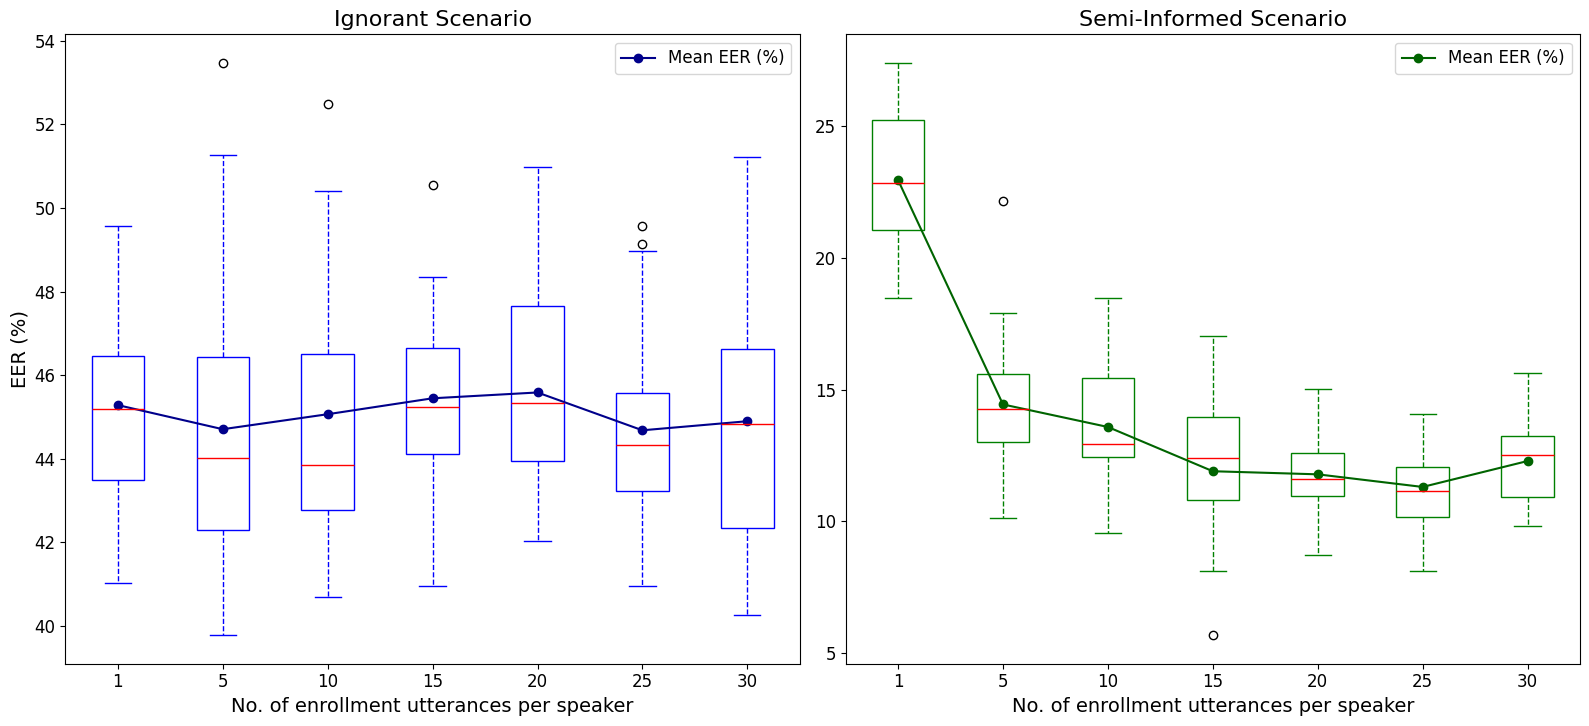

In [11]:
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')

# # Customizing the overall appearance
# plt.suptitle('EER (%) of test-clean-other', fontsize=18, fontweight='normal')

# Ignorant Scenario
ignorant_means = full_df.groupby('num_of_enroll')['eer_ignorant'].mean()
ignorant_data = [group['eer_ignorant'].values for _, group in full_df.groupby('num_of_enroll')]
axs[0].boxplot(ignorant_data, labels=ignorant_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='blue'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='blue', linestyle='--'),
               capprops=dict(color='blue'))
axs[0].plot(range(1, len(ignorant_means) + 1), ignorant_means, color='darkblue', marker='o', linestyle='-', label='Mean EER (%)')
axs[0].set_title('Ignorant Scenario', fontsize=16, fontweight='normal')
axs[0].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[0].set_ylabel('EER (%)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Semi-Informed Scenario
lazy_informed_means = full_df.groupby('num_of_enroll')['eer_lazy-informed'].mean()
lazy_informed_data = [group['eer_lazy-informed'].values for _, group in full_df.groupby('num_of_enroll')]
axs[1].boxplot(lazy_informed_data, labels=lazy_informed_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='green'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='green', linestyle='--'),
               capprops=dict(color='green'))
axs[1].plot(range(1, len(lazy_informed_means) + 1), lazy_informed_means, color='darkgreen', marker='o', linestyle='-', label='Mean EER (%)')
axs[1].set_title('Semi-Informed Scenario', fontsize=16, fontweight='normal')
axs[1].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('overall_stats/boxplots/knnvc_tco_enrolls.png')
plt.savefig('overall_stats/boxplots/knnvc_tco_enrolls.pdf')  
plt.show()




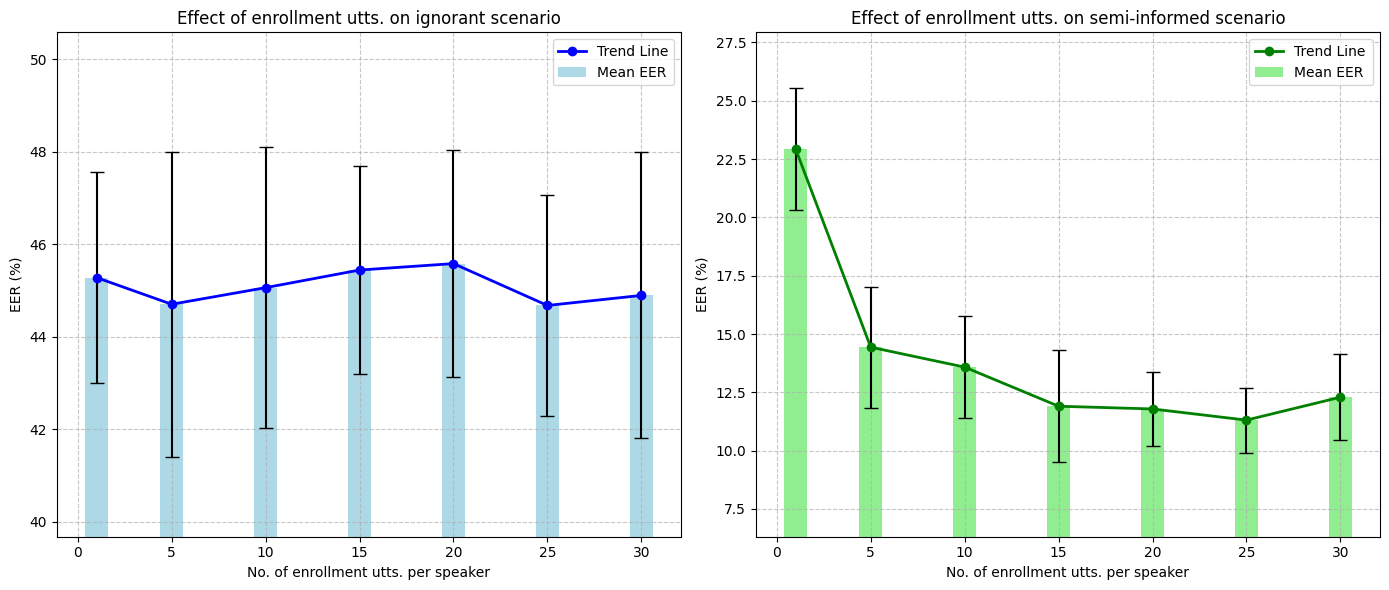

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for eer_ignorant
axs[0].bar(overall_stats.index, overall_stats['eer_ignorant']['mean'], yerr=overall_stats['eer_ignorant']['std'], capsize=5, color='lightblue', width=1.2, label='Mean EER')
axs[0].plot(overall_stats.index, overall_stats['eer_ignorant']['mean'], marker='o', color='blue', linestyle='-', linewidth=2, label='Trend Line')
axs[0].set_title('Effect of enrollment utts. on ignorant scenario')
axs[0].set_xlabel('No. of enrollment utts. per speaker')
axs[0].set_ylabel('EER (%)')
axs[0].set_ylim(min(overall_stats['eer_ignorant']['mean']) - 5, max(overall_stats['eer_ignorant']['mean']) + 5)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Bar chart for eer_lazy-informed
axs[1].bar(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], yerr=overall_stats['eer_lazy-informed']['std'], capsize=5, color='lightgreen', width=1.2, label='Mean EER ')
axs[1].plot(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], marker='o', color='green', linestyle='-', linewidth=2, label='Trend Line')
axs[1].set_title('Effect of enrollment utts. on semi-informed scenario')
axs[1].set_xlabel('No. of enrollment utts. per speaker')
axs[1].set_ylabel('EER (%)')
axs[1].set_ylim(min(overall_stats['eer_lazy-informed']['mean']) -5, max(overall_stats['eer_lazy-informed']['mean']) + 5)

axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.savefig('overall_stats/bar_charts/knnvc_tco_enrolls.png')
plt.savefig('overall_stats/bar_charts/knnvc_tco_enrolls.pdf')  

plt.tight_layout()
plt.show()



### 2. Evaluation with ls-train-other-500 (795 from the 1166 speakers)
The speakers with less than 120 utterances are filtered out from the dataset

### a) StarGAN-VC

In [13]:
file_pattern = "results_stargan_enroll/ls-train-other-500/stargan_to500_num_enrolls#*.txt" 

In [14]:
all_files = glob.glob(file_pattern)

Averaging over 5 different target selections

In [15]:
all_dfs = []
for filename in all_files:
    df = pd.read_csv(filename, sep='\s+')
    df['eer_ignorant'] *= 100  # Convert to percentage
    df['eer_lazy-informed'] *= 100  # Convert to percentage
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)



In [16]:
# Aggregate and calculate overall mean and standard deviation for each number of enroll
overall_stats = full_df.groupby('num_of_enrolls').agg({'eer_ignorant': ['mean', 'std'], 'eer_lazy-informed': ['mean', 'std']})

condition = (
    (full_df['num_of_enrolls'] % 10 == 0)  # Includes multiples of 5
)

# Apply the condition to filter the DataFrame
full_df = full_df[condition]

# Aggregate and calculate mean and standard deviation for each group of 'num'
overall_stats = full_df.groupby('num_of_enrolls').agg({
    'eer_ignorant': ['mean', 'std'],
    'eer_lazy-informed': ['mean', 'std']
})
overall_stats.to_csv('overall_stats/overall_stats_stargan_to500_enrolls.csv', index=True)  # Set index=False if you do not want to include the DataFrame index as a column in the CSV file

# Display the resulting statistics
print("Overall Statistics for train-other-500:")
display(overall_stats)

Overall Statistics for train-other-500:


eer_ignorant           eer_lazy-informed          
                       mean       std              mean       std
num_of_enrolls                                                   
10                27.808872  0.702597         15.719510  0.688485
20                27.713704  0.590762         15.208671  0.724847
30                27.603140  0.698428         15.022391  0.522397
40                27.657386  0.775319         14.943746  0.760336
50                27.469495  0.734786         14.897872  0.692409
60                27.559264  0.762157         14.865886  0.667028
70                27.538481  0.821173         14.865511  0.735550
80                27.560738  0.676018         14.686720  0.691091
90                27.539262  0.834988         14.845446  0.766044
100               27.578427  0.748268         14.824878  0.610354

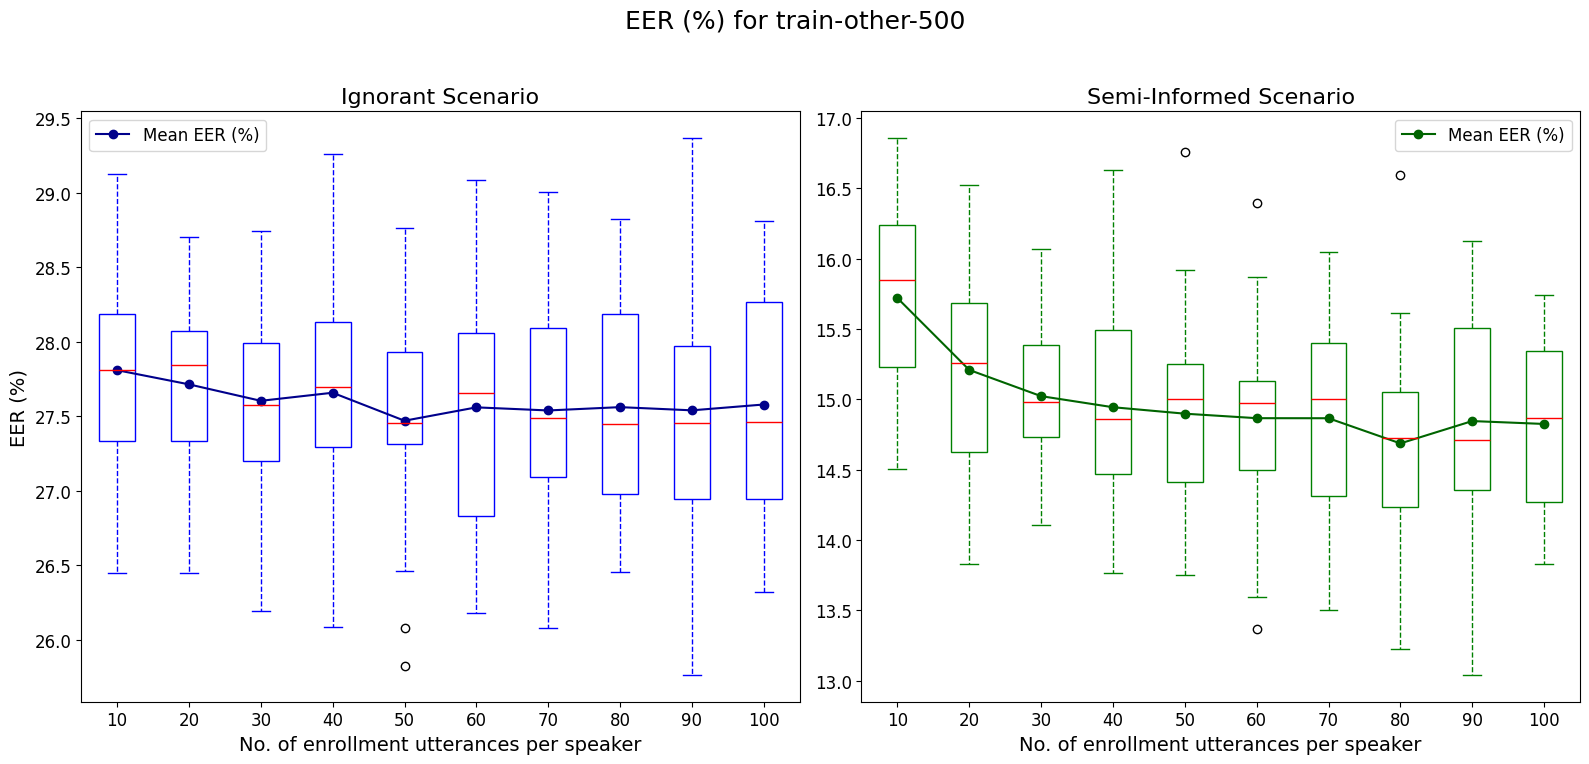

In [17]:
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')

# Customizing the overall appearance
plt.suptitle('EER (%) for train-other-500', fontsize=18, fontweight='normal')

# Ignorant Scenario
ignorant_means = full_df.groupby('num_of_enrolls')['eer_ignorant'].mean()
ignorant_data = [group['eer_ignorant'].values for _, group in full_df.groupby('num_of_enrolls')]
axs[0].boxplot(ignorant_data, labels=ignorant_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='blue'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='blue', linestyle='--'),
               capprops=dict(color='blue'))
axs[0].plot(range(1, len(ignorant_means) + 1), ignorant_means, color='darkblue', marker='o', linestyle='-', label='Mean EER (%)')
axs[0].set_title('Ignorant Scenario', fontsize=16, fontweight='normal')
axs[0].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[0].set_ylabel('EER (%)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Semi-Informed Scenario
lazy_informed_means = full_df.groupby('num_of_enrolls')['eer_lazy-informed'].mean()
lazy_informed_data = [group['eer_lazy-informed'].values for _, group in full_df.groupby('num_of_enrolls')]
axs[1].boxplot(lazy_informed_data, labels=lazy_informed_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='green'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='green', linestyle='--'),
               capprops=dict(color='green'))
axs[1].plot(range(1, len(lazy_informed_means) + 1), lazy_informed_means, color='darkgreen', marker='o', linestyle='-', label='Mean EER (%)')
axs[1].set_title('Semi-Informed Scenario', fontsize=16, fontweight='normal')
axs[1].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('overall_stats/boxplots/stargan_to500_enrolls.png')
plt.savefig('overall_stats/boxplots/stargan_to500_enrolls.pdf')  
plt.show()

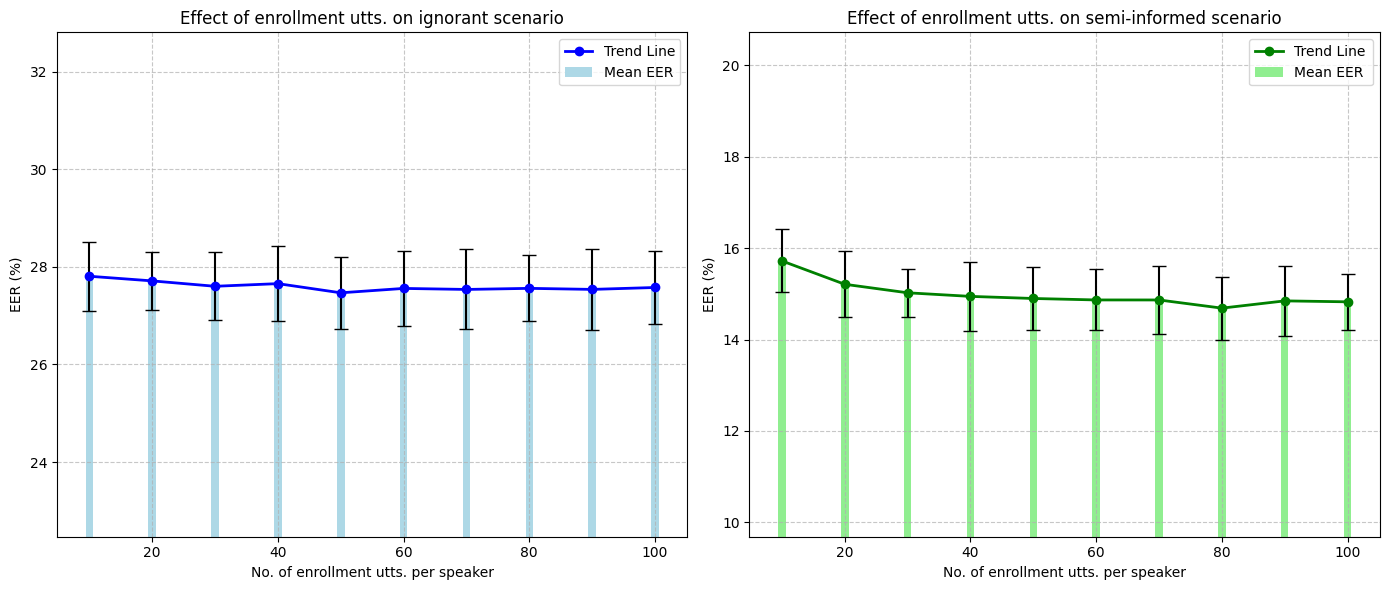

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for eer_ignorant
axs[0].bar(overall_stats.index, overall_stats['eer_ignorant']['mean'], yerr=overall_stats['eer_ignorant']['std'], capsize=5, color='lightblue', width=1.2, label='Mean EER')
axs[0].plot(overall_stats.index, overall_stats['eer_ignorant']['mean'], marker='o', color='blue', linestyle='-', linewidth=2, label='Trend Line')
axs[0].set_title('Effect of enrollment utts. on ignorant scenario')
axs[0].set_xlabel('No. of enrollment utts. per speaker')
axs[0].set_ylabel('EER (%)')
axs[0].set_ylim(min(overall_stats['eer_ignorant']['mean']) - 5, max(overall_stats['eer_ignorant']['mean']) + 5)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Bar chart for eer_lazy-informed
axs[1].bar(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], yerr=overall_stats['eer_lazy-informed']['std'], capsize=5, color='lightgreen', width=1.2, label='Mean EER ')
axs[1].plot(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], marker='o', color='green', linestyle='-', linewidth=2, label='Trend Line')
axs[1].set_title('Effect of enrollment utts. on semi-informed scenario')
axs[1].set_xlabel('No. of enrollment utts. per speaker')
axs[1].set_ylabel('EER (%)')
axs[1].set_ylim(min(overall_stats['eer_lazy-informed']['mean']) -5, max(overall_stats['eer_lazy-informed']['mean']) + 5)

axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.savefig('overall_stats/bar_charts/stargan_to500_enrolls.png')
plt.savefig('overall_stats/bar_charts/stargan_to500_enrolls.pdf')  

plt.tight_layout()
plt.show()



### b) kNN-VC model


In [19]:
file_pattern = "results_knnvc_enroll/ls-train-other-500/knnvc_to500_num_enrolls#*.txt" 

In [20]:
all_files = glob.glob(file_pattern)


Aggregate over all the target selections

In [49]:
all_dfs = []
for filename in all_files:
    df = pd.read_csv(filename, sep='\s+')
    df['eer_ignorant'] *= 100  # Convert to percentage
    df['eer_lazy-informed'] *= 100  # Convert to percentage
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)

In [23]:
# Incrementing by 1 till 10, and by 5 thereafter
condition = (
    (full_df['num_of_enrolls'] % 10 == 0)  # Includes multiples of 5
)

# Apply the condition to filter the DataFrame
full_df = full_df[condition]

# Aggregate and calculate mean and standard deviation for each group of 'num'
overall_stats = full_df.groupby('num_of_enrolls').agg({
    'eer_ignorant': ['mean', 'std'],
    'eer_lazy-informed': ['mean', 'std']
})
overall_stats.to_csv('overall_stats/overall_stats_knnvc_to500_enrolls.csv', index=True)  # Set index=False if you do not want to include the DataFrame index as a column in the CSV file

# Display the resulting statistics
display(overall_stats)


eer_ignorant           eer_lazy-informed          
                       mean       std              mean       std
num_of_enrolls                                                   
10                27.808872  0.702597         15.719510  0.688485
20                27.713704  0.590762         15.208671  0.724847
30                27.603140  0.698428         15.022391  0.522397
40                27.657386  0.775319         14.943746  0.760336
50                27.469495  0.734786         14.897872  0.692409
60                27.559264  0.762157         14.865886  0.667028
70                27.538481  0.821173         14.865511  0.735550
80                27.560738  0.676018         14.686720  0.691091
90                27.539262  0.834988         14.845446  0.766044
100               27.578427  0.748268         14.824878  0.610354

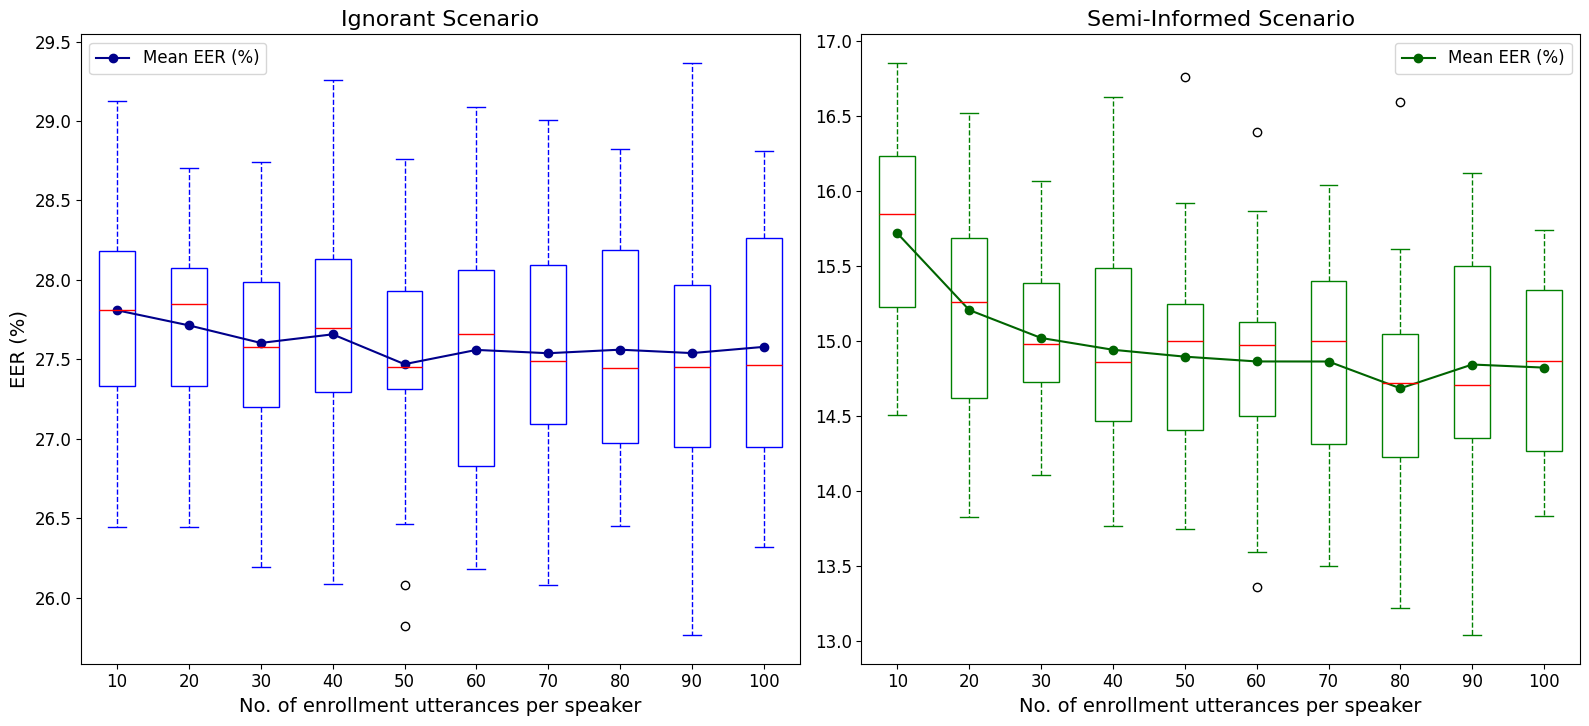

In [25]:
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')

# # Customizing the overall appearance
# plt.suptitle('EER (%) for train-other-500', fontsize=18, fontweight='normal')

# Ignorant Scenario
ignorant_means = full_df.groupby('num_of_enrolls')['eer_ignorant'].mean()
ignorant_data = [group['eer_ignorant'].values for _, group in full_df.groupby('num_of_enrolls')]
axs[0].boxplot(ignorant_data, labels=ignorant_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='blue'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='blue', linestyle='--'),
               capprops=dict(color='blue'))
axs[0].plot(range(1, len(ignorant_means) + 1), ignorant_means, color='darkblue', marker='o', linestyle='-', label='Mean EER (%)')
axs[0].set_title('Ignorant Scenario', fontsize=16, fontweight='normal')
axs[0].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[0].set_ylabel('EER (%)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Lazy-Informed Scenario
lazy_informed_means = full_df.groupby('num_of_enrolls')['eer_lazy-informed'].mean()
lazy_informed_data = [group['eer_lazy-informed'].values for _, group in full_df.groupby('num_of_enrolls')]
axs[1].boxplot(lazy_informed_data, labels=lazy_informed_means.index, patch_artist=True, 
               boxprops=dict(facecolor='white', color='green'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='green', linestyle='--'),
               capprops=dict(color='green'))
axs[1].plot(range(1, len(lazy_informed_means) + 1), lazy_informed_means, color='darkgreen', marker='o', linestyle='-', label='Mean EER (%)')
axs[1].set_title('Semi-Informed Scenario', fontsize=16, fontweight='normal')
axs[1].set_xlabel('No. of enrollment utterances per speaker', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('overall_stats/boxplots/knnvc_to500_enrolls.png')
plt.savefig('overall_stats/boxplots/knnvc_to500_enrolls.pdf')  
plt.show()

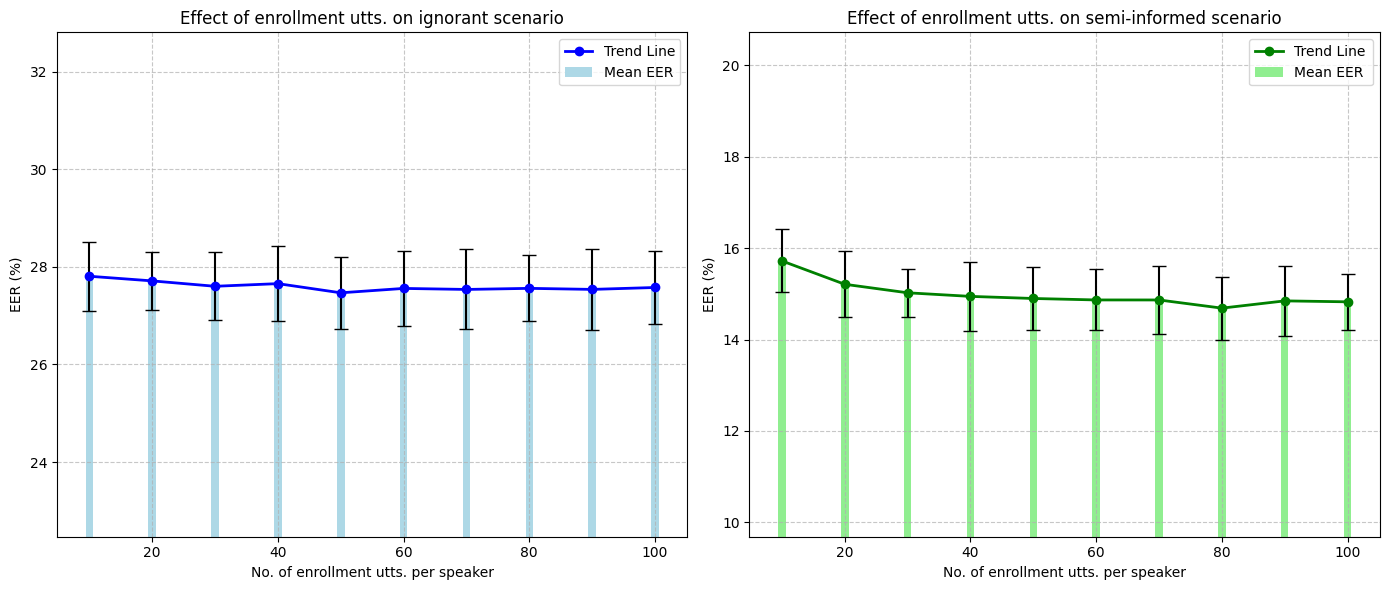

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for eer_ignorant
axs[0].bar(overall_stats.index, overall_stats['eer_ignorant']['mean'], yerr=overall_stats['eer_ignorant']['std'], capsize=5, color='lightblue', width=1.2, label='Mean EER')
axs[0].plot(overall_stats.index, overall_stats['eer_ignorant']['mean'], marker='o', color='blue', linestyle='-', linewidth=2, label='Trend Line')
axs[0].set_title('Effect of enrollment utts. on ignorant scenario')
axs[0].set_xlabel('No. of enrollment utts. per speaker')
axs[0].set_ylabel('EER (%)')
axs[0].set_ylim(min(overall_stats['eer_ignorant']['mean']) - 5, max(overall_stats['eer_ignorant']['mean']) + 5)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Bar chart for eer_lazy-informed
axs[1].bar(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], yerr=overall_stats['eer_lazy-informed']['std'], capsize=5, color='lightgreen', width=1.2, label='Mean EER ')
axs[1].plot(overall_stats.index, overall_stats['eer_lazy-informed']['mean'], marker='o', color='green', linestyle='-', linewidth=2, label='Trend Line')
axs[1].set_title('Effect of enrollment utts. on semi-informed scenario')
axs[1].set_xlabel('No. of enrollment utts. per speaker')
axs[1].set_ylabel('EER (%)')
axs[1].set_ylim(min(overall_stats['eer_lazy-informed']['mean']) -5, max(overall_stats['eer_lazy-informed']['mean']) + 5)

axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.savefig('overall_stats/bar_charts/knnvc_to500_enrolls.png')
plt.savefig('overall_stats/bar_charts/knnvc_to500_enrolls.pdf')  

plt.tight_layout()
plt.show()

